In [4]:
!sudo apt update
!sudo apt install -y build-essential autoconf libtool pkg-config python3-dev \
    python3-pip python3-numpy git flex bison libbz2-dev

!wget -O - https://apt.kitware.com/keys/kitware-archive-latest.asc 2>/dev/null | sudo apt-key add -
!sudo apt-add-repository 'deb https://apt.kitware.com/ubuntu/ bionic main'
!sudo apt-get update && apt-get --allow-unauthenticated install -y \
    cmake \
    kitware-archive-keyring

# feel free to use a more elegant solution to make /usr/bin/cmake the default one
!sudo rm $(which cmake)
!$(which cmake) --version

!pip3 install -Uv nle

Get:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,626 B]
Hit:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Get:3 http://security.ubuntu.com/ubuntu jammy-security InRelease [110 kB]
Hit:4 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:5 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [119 kB]
Get:6 https://ppa.launchpadcontent.net/c2d4u.team/c2d4u4.0+/ubuntu jammy InRelease [18.1 kB]
Get:7 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ Packages [44.8 kB]
Get:8 http://security.ubuntu.com/ubuntu jammy-security/universe amd64 Packages [1,009 kB]
Get:9 http://archive.ubuntu.com/ubuntu jammy-backports InRelease [109 kB]
Hit:10 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Get:11 http://security.ubuntu.com/ubuntu jammy-security/main amd64 Packages [1,131 kB]
Get:12 http://archive.ubuntu.com/ubuntu jammy-updates/universe amd64 Packages [1,274 kB]
Hit:13 https://ppa.launchpa

In [5]:
!pip install minihack

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 227.4/227.4 kB 5.9 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for minihack: filename=minihack-0.1.5-py3-none-any.whl size=265154 sha256=d75c4e44ace80b6924cbe75abf3cbb0c02eb148075472d13a890d958384cee32
  Stored in directory: /root/.cache/pip/wheels/ae/63/66/5cff213ff21473ce5e15028cb185f16f79f37fff557dfc8eef
Successfully built minihack


In [6]:
import math
import os
import random

import gym
import matplotlib.pyplot as plt
import minihack
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from gym import spaces
from nle import nethack
from PIL import Image
from torch import flatten
from torch.nn import (BatchNorm2d, Conv2d, CrossEntropyLoss, Dropout, Linear,
                      MaxPool2d, Module, ReLU, Sequential, Softmax)
import gym
import cv2
cv2.ocl.setUseOpenCL(False)
import random
from gym import spaces
from collections import deque
import math
from torch.optim import Adam
from torch.nn import MSELoss
import torch
import copy
import random
import numpy as np
import gym
from gym import spaces
from google.colab import drive
drive.mount('/content/drive')
widths = 316
heights = 84

Mounted at /content/drive


In [52]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [53]:
class WarpFrame(gym.ObservationWrapper):
    def __init__(self, env):
        """Warp frames to 84x84 as done in the Nature paper and later work.
        Expects inputs to be of shape height x width x num_channels
        """
        gym.ObservationWrapper.__init__(self, env)
        self.width = widths
        self.height = heights
        self.observation_space = spaces.Box(
            low=0, high=255, shape=(self.height, self.width, 1), dtype=np.uint8
        )
        self.LastFullImg = None

    def observation(self, frame):
        self.LastFullImg = frame["pixel"]

        frame = frame["pixel"]
        frame = cv2.cvtColor(frame, cv2.COLOR_RGB2GRAY)
        frame = cv2.resize(
            frame, (self.width, self.height), interpolation=cv2.INTER_AREA
        )
        return frame[:, :, None]

    def get_last_full_img(self):
        return self.LastFullImg

In [54]:
class ImageDQN(nn.Module):
    """
    A basic implementation of a Deep Q-Network. The architecture is the same as that described in the
    Nature DQN paper.
    """

    def __init__(self, observation_space: spaces.Box, action_space: spaces.Discrete):
        """
        Initialise the DQN
        :param observation_space: the state space of the environment
        :param action_space: the action space of the environment
        """
        super().__init__()

        self.cnn_layer_one = torch.nn.Conv2d(in_channels=1, stride=4, kernel_size=(8, 8), out_channels=32) # output = 32x19x19
        self.cnn_layer_two = torch.nn.Conv2d(in_channels=32, stride=2, kernel_size=(4, 4), out_channels=64) # output = 64x9x9
        self.cnn_layer_three = torch.nn.Conv2d(in_channels=64, stride=1, kernel_size=(3, 3), out_channels=64) # output = 64x7x7
        self.relu_layer = torch.nn.ReLU()

        dummy_input = torch.zeros(1, 1, heights, widths)
        conv_out = self.forward_conv(dummy_input)
        conv_out_shape = int(np.prod(conv_out.shape))

        self.final_hidden_layer = torch.nn.Linear(in_features=conv_out_shape, out_features=512)
        self.final_layer = torch.nn.Linear(in_features=512, out_features=action_space.n)


    def forward_conv(self, x):
        x = self.relu_layer(self.cnn_layer_one(x))
        x = self.relu_layer(self.cnn_layer_two(x))
        x = self.relu_layer(self.cnn_layer_three(x))
        return x

    def forward(self, x):
        x = x.to(device)
        x = self.forward_conv(x=x)
        x = x.view(x.size(0), -1)

        final_hidden_output = self.final_hidden_layer(x)
        relu_flattened = self.relu_layer(final_hidden_output)

        output = self.final_layer(relu_flattened)
        output = output.to(device)

        return output

In [56]:

class ReplayBuffer:
    """
    Simple storage for transitions from an environment.
    """

    def __init__(self, size):
        """
        Initialise a buffer of a given size for storing transitions
        :param size: the maximum number of transitions that can be stored
        """
        self._storage = []
        self._maxsize = size
        self._next_idx = 0

    def __len__(self):
        return len(self._storage)

    def add(self, state, action, reward, next_state, done):
        """
        Add a transition to the buffer. Old transitions will be overwritten if the buffer is full.
        :param state: the agent's initial state
        :param action: the action taken by the agent
        :param reward: the reward the agent received
        :param next_state: the subsequent state
        :param done: whether the episode terminated
        """
        data = (state, action, reward, next_state, done)

        if self._next_idx >= len(self._storage):
            self._storage.append(data)
        else:
            self._storage[self._next_idx] = data
        self._next_idx = (self._next_idx + 1) % self._maxsize

    def _encode_sample(self, indices):
        states, actions, rewards, next_states, dones = [], [], [], [], []
        for i in indices:
            data = self._storage[i]
            state, action, reward, next_state, done = data
            states.append(np.array(state, copy=False))
            actions.append(action)
            rewards.append(reward)
            next_states.append(np.array(next_state, copy=False))
            dones.append(done)
        return {
            "state": np.array(states),
            "action": np.array(actions),
            "reward": np.array(rewards),
            "next_state": np.array(next_states),
            "done": np.array(dones),
        }

    def sample(self, batch_size):
        """
        Randomly sample a batch of transitions from the buffer.
        :param batch_size: the number of transitions to sample
        :return: a mini-batch of sampled transitions
        """
        indices = np.random.randint(0, len(self._storage) - 1, size=batch_size)
        return self._encode_sample(indices), indices

In [57]:
class DQNAgent:
    def __init__(
        self,
        observation_space: spaces.Box,
        action_space: spaces.Discrete,
        replay_buffer: ReplayBuffer,
        use_double_dqn,
        lr,
        batch_size,
        gamma,
    ):
        """
        Initialise the DQN algorithm using the Adam optimiser
        :param action_space: the action space of the environment
        :param observation_space: the state space of the environment
        :param replay_buffer: storage for experience replay
        :param lr: the learning rate for Adam
        :param batch_size: the batch size
        :param gamma: the discount factor
        """
        self.dqn_model = ImageDQN(
            observation_space=observation_space,
            action_space=action_space
        )
        self.dqn_model = self.dqn_model.to(device)
        self.target_dqn = copy.deepcopy(self.dqn_model)
        self.target_dqn = self.target_dqn.to(device)
        self.optimizer = Adam(self.dqn_model.parameters(), lr=lr)
        self.loss_fn = MSELoss()
        self.replay_buffer = replay_buffer
        self.gamma = gamma
        self.batch_size = batch_size


    def optimise_td_loss(self):
        """
        Optimise the TD-error over a single minibatch of transitions
        :return: the loss
        """
        replay_entries, mini_batch_size = self.replay_buffer.sample(self.batch_size)

        state = torch.tensor(replay_entries["state"], dtype=torch.float32).to(device)
        next_state = torch.tensor(replay_entries["next_state"], dtype=torch.float32).to(device)
        reward = torch.tensor(replay_entries["reward"], dtype=torch.float32).to(device)
        done = torch.tensor(replay_entries["done"], dtype=torch.float32).to(device)

        state = torch.reshape(state, (64, 1, heights, widths)).to(device)
        next_state = torch.reshape(next_state, (64, 1, heights, widths)).to(device)

        q_target = self.target_dqn(next_state).max(dim=1)[0]
        q_target = q_target.to(device)
        y_j = reward
        y_j += (1 - done) * self.gamma * q_target

        predict = self.dqn_model(state).to(device).gather(dim=1, index=torch.tensor(replay_entries["action"]).to(device).unsqueeze(-1)).squeeze()

        self.optimizer.zero_grad()
        loss = self.loss_fn(predict, y_j)
        loss.backward()
        self.optimizer.step()

        return loss


    def update_target_network(self):
        """
        Update the target Q-network by copying the weights from the current Q-network
        """
        self.target_dqn = copy.deepcopy(self.dqn_model)
        self.target_dqn = self.target_dqn.to(device)

    def act(self, state: np.ndarray):
        """
        Select an action greedily from the Q-network given the state
        :param state: the current state
        :return: the action to take
        """
        state_value = state.__array__().astype('float32')
        tensor_state = torch.from_numpy(state_value)
        reshaped_tensor = torch.reshape(tensor_state, (1, 1, heights, widths))
        reshaped_tensor.to(device)
        output_action = self.dqn_model(reshaped_tensor).to(device)
        action = torch.argmax(output_action)
        action_value = torch.max(output_action)
        return action.item(), action_value.item()

In [58]:
def runEnv(hyperParams,envName,  agent = None):
    hyper_params = hyperParams

    for item in hyper_params:
        print(f"{item}: {hyper_params[item]}")

    np.random.seed(hyper_params["seed"])
    random.seed(hyper_params["seed"])

    env = gym.make(hyper_params["env"], actions=hyper_params["actions"], observation_keys=("glyphs", "chars", "colors", "pixel") )# , reward_manager=reward_manager)
    env.seed(hyper_params["seed"])

    env = WarpFrame(env)

    replay_buffer = ReplayBuffer(hyper_params["replay-buffer-size"])

    if agent == None:
        agent = DQNAgent(
            observation_space=env.observation_space,
            action_space=env.action_space,
            replay_buffer=replay_buffer,
            use_double_dqn=False,
            lr=hyper_params["learning-rate"],
            batch_size=hyper_params["batch-size"],
            gamma=hyper_params["discount-factor"],
        )

    eps_timesteps = hyper_params["eps-fraction"] * float(hyper_params["num-steps"])
    episode_rewards = [0.0]

    state = env.reset()
    state = state
    #print('shape = ', state["pixel"].shape)

    earlyStop = 0.9
    NumES = 10
    countES = 0

    losses = []
    episode_losses = []
    action_values = []
    episode_steps = []
    episode_action_values = []

    eps_threshold = hyper_params["eps-start"]
    eps_threshold -= 0.0125
    for t in range(hyper_params["num-steps"]):
        fraction = min(1.0, float(t) / eps_timesteps)
        eps_threshold = hyper_params["eps-start"] + fraction * (
            hyper_params["eps-end"] - hyper_params["eps-start"]
        )

        sample = random.random()
        if sample < eps_threshold:
            action = np.random.choice(env.action_space.n)
        else:
            action, action_value = agent.act(state)
            action_values.append(action_value)

        next_state, reward, done, info = env.step(action)
        agent.replay_buffer.add(
            state=state,
            action=action,
            reward=reward,
            next_state=next_state,
            done=done
        )

        episode_rewards[-1] += reward
        if done:
            #eps_threshold -= 0.0125
            if eps_threshold < hyper_params["eps-end"]:
              eps_threshold = hyper_params["eps-end"]

            print(f"episode {len(episode_rewards)} done")
            episode_action_values.append(np.mean(action_values))
            if losses:
              episode_losses.append(np.mean(losses))
            if episode_steps:
                episode_steps.append(t-sum(episode_steps))
            else:
                episode_steps.append(t)
            if len(episode_steps) == hyper_params["num_max_Episodes"]:
                break


            action_values = []
            losses = []
            state = env.reset()
            state = state
            episode_rewards.append(0.0)

        if (
            #t > hyper_params["learning-starts"]
            #and t % hyper_params["learning-freq"] == 0
            len(episode_steps) >= 15
        ):
            loss = agent.optimise_td_loss()
            losses.append(loss.item())

        if (
            t > hyper_params["learning-starts"]
            and t % hyper_params["target-update-freq"] == 0
        ):
            agent.update_target_network()

        num_episodes = len(episode_rewards)
        state = next_state

        if (
            done
            and hyper_params["print-freq"] is not None
            and len(episode_rewards) % hyper_params["print-freq"] == 0
        ):
            mean_100ep_reward = round(np.mean(episode_rewards[-101:-1]), 1)
            print("********************************************************")
            print(f"Episode return: {episode_rewards[-2]}")
            print("steps: {}".format(t))
            print("episodes: {}".format(num_episodes))
            print("mean 100 episode reward: {}".format(mean_100ep_reward))
            print("% time spent exploring: {}".format(int(100 * eps_threshold)))
            print("********************************************************")

            #if mean_100ep_reward >= earlyStop:
            #    countES += 1
            #    if countES == NumES:
            #        break
            #else:
            #    countES = 0

    torch.save(agent.dqn_model.state_dict(), f'/content/drive/MyDrive/rl/Assignment/rlweights/dqn_weights_{envName}.pth')

    plt.plot([i for i in range(len(episode_rewards))], episode_rewards)
    plt.title('Episode Returns')
    plt.xlabel('Episode')
    plt.ylabel('Return')
    plt.show()

    plt.plot([i for i in range(len(episode_losses))], episode_losses)
    plt.title('Average Episode Losses')
    plt.xlabel('Episode')
    plt.ylabel('Average Loss')
    plt.show()

    plt.plot([i for i in range(len(episode_action_values))], episode_action_values)
    plt.title('Average Episode Action Values')
    plt.xlabel('Episode')
    plt.ylabel('Average Action Value')
    plt.show()

    plt.plot([i for i in range(len(episode_steps))], episode_steps)
    plt.title('Steps Per Episode')
    plt.xlabel('Episode')
    plt.ylabel('Steps')
    plt.show()

    return agent

In [59]:
def makeVideo(agent, hyper_params, envName):
    hyper_params = hyper_params
    videoFrames = []

    #play game###########################################################
    for item in hyper_params:
      print(f"{item}: {hyper_params[item]}")

    env = gym.make(hyper_params["env"], actions=hyper_params["actions"], observation_keys=("glyphs", "chars", "colors", "pixel"))
    env = WarpFrame(env)
    state = env.reset()

    last_full_img = env.get_last_full_img()
    videoFrames.append(last_full_img)
    sumReward = []

    for t in range(hyper_params["num-steps"]):
        action, action_value = agent.act(state)
        print("act = ", action)
        next_state, reward, done, info = env.step(action)
        last_full_img = env.get_last_full_img()
        videoFrames.append(last_full_img)
        if done:
            print(reward)
            break
        state = next_state

    print(videoFrames[1].shape)

###################################################################################

    output_video_path = f'{envName}.mp4'

    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    fps = 5  # Frames per second
    frame_width, frame_height = videoFrames[0].shape[1], videoFrames[0].shape[0]

    out = cv2.VideoWriter(output_video_path, fourcc, fps, (frame_width, frame_height))

    for image in videoFrames:

        frame = cv2.cvtColor(np.uint8(image), cv2.COLOR_RGB2BGR)
        out.write(frame)
    out.release()

    print(f'Video saved at {output_video_path}')

In [60]:
ACTION_SPACE = (
      nethack.CompassDirection.N,
      nethack.CompassDirection.E,
      nethack.CompassDirection.S,
      nethack.CompassDirection.W,
)

envName = "MiniHack-Room-5x5-v0"

hyperParams = {
    "seed": 42,  # which seed to use
    "env": envName,  # name of the game
    "replay-buffer-size": 3000,  # replay buffer size
    "learning-rate": 1e-5,  # learning rate for Adam optimizer
    "discount-factor": 0.99,  # discount factor
    "num-steps": 10000,  # total number of steps to run the environment for
    "num_max_Episodes": 100, #if num steps not reached, cap number of episodes
    "batch-size": 64,  # number of transitions to optimize at the same time
    "learning-starts": 15,  # number of episodes before learning starts
    "learning-freq": 4,  # number of iterations between every optimization step
    "use-double-dqn": True,  # use double deep Q-learning
    "target-update-freq": 100,  # number of iterations between every target network update
    "eps-start": 1.0,  # e-greedy start threshold
    "eps-end": 0.01,  # e-greedy end threshold
    "eps-fraction": 0.1,  # fraction of num-steps
    "print-freq": 1,
    "actions": ACTION_SPACE,
    }

trainedAgent = runEnv(hyperParams, envName)
makeVideo(trainedAgent, hyperParams, envName)

seed: 42
env: MiniHack-Room-5x5-v0
replay-buffer-size: 3000
learning-rate: 1e-05
discount-factor: 0.99
num-steps: 10000
num_max_Episodes: 100
batch-size: 64
learning-starts: 15
learning-freq: 4
use-double-dqn: True
target-update-freq: 100
eps-start: 1.0
eps-end: 0.01
eps-fraction: 0.1
print-freq: 1
actions: (<CompassDirection.N: 107>, <CompassDirection.E: 108>, <CompassDirection.S: 106>, <CompassDirection.W: 104>)
episode 1 done
********************************************************
Episode return: -0.20000000000000004
steps: 99
episodes: 2
mean 100 episode reward: -0.2
% time spent exploring: 90
********************************************************
episode 2 done
********************************************************
Episode return: 0.96
steps: 117
episodes: 3
mean 100 episode reward: 0.4
% time spent exploring: 88
********************************************************
episode 3 done
********************************************************
Episode return: -0.3300000000000001


KeyboardInterrupt: ignored

In [19]:
makeVideo(trainedAgent, hyperParams, envName) #just pass the hyperParams for the 1 run and setting up env

seed: 42
env: MiniHack-Room-5x5-v0
replay-buffer-size: 3000
learning-rate: 1e-05
discount-factor: 0.99
num-steps: 10000
num_max_Episodes: 100
batch-size: 64
learning-starts: 15
learning-freq: 4
use-double-dqn: True
target-update-freq: 100
eps-start: 1.0
eps-end: 0.01
eps-fraction: 0.1
print-freq: 1
actions: (<CompassDirection.N: 107>, <CompassDirection.E: 108>, <CompassDirection.S: 106>, <CompassDirection.W: 104>)
act =  3
act =  3
act =  3
act =  3
act =  3
act =  3
act =  3
act =  3
act =  3
act =  3
act =  3
act =  3
act =  3
act =  3
act =  3
act =  3
act =  3
act =  3
act =  3
act =  3
act =  3
act =  3
act =  3
act =  3
act =  3
act =  3
act =  3
act =  3
act =  3
act =  3
act =  3
act =  3
act =  3
act =  3
act =  3
act =  3
act =  3
act =  3
act =  3
act =  3
act =  3
act =  3
act =  3
act =  3
act =  3
act =  3
act =  3
act =  3
act =  3
act =  3
act =  3
act =  3
act =  3
act =  3
act =  3
act =  3
act =  3
act =  3
act =  3
act =  3
act =  3
act =  3
act =  3
act =  3
act = 

seed: 42
env: MiniHack-Room-Random-5x5-v0
replay-buffer-size: 3000
learning-rate: 1e-05
discount-factor: 1
num-steps: 100000
num_max_Episodes: 500
batch-size: 64
learning-starts: 1000
learning-freq: 4
use-double-dqn: True
target-update-freq: 100
eps-start: 1.0
eps-end: 0.01
eps-fraction: 0.01
print-freq: 1
actions: (<CompassDirection.N: 107>, <CompassDirection.E: 108>, <CompassDirection.S: 106>, <CompassDirection.W: 104>)
episode 1 done
********************************************************
Episode return: 1.0
steps: 5
episodes: 2
mean 100 episode reward: 1.0
% time spent exploring: 97
********************************************************
episode 2 done
********************************************************
Episode return: 0.88
steps: 69
episodes: 3
mean 100 episode reward: 0.9
% time spent exploring: 96
********************************************************
episode 3 done
********************************************************
Episode return: 0.95
steps: 82
episodes: 4
mean 

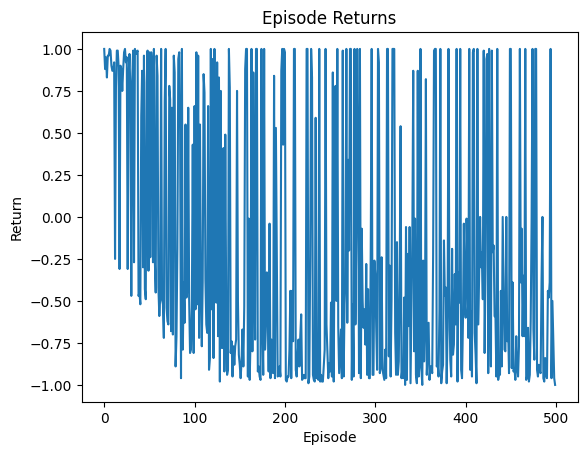

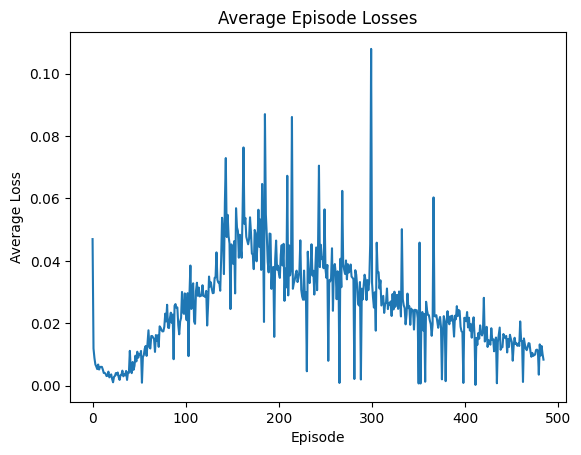

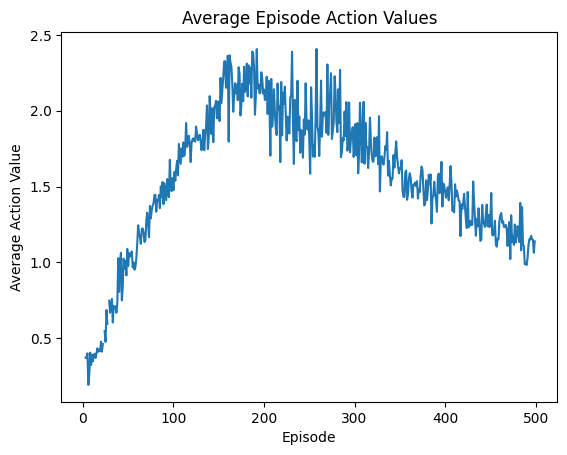

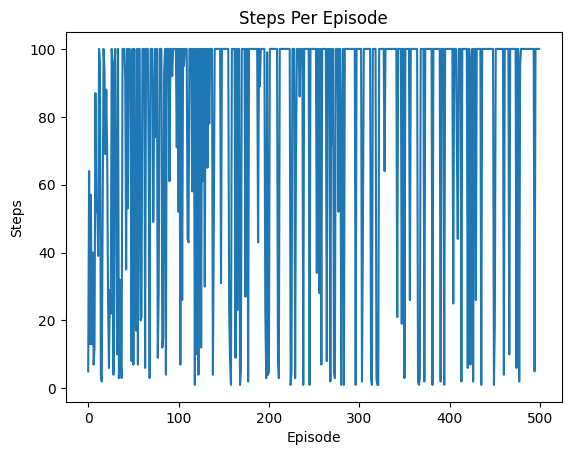

In [42]:

ACTION_SPACE = (
      nethack.CompassDirection.N,
      nethack.CompassDirection.E,
      nethack.CompassDirection.S,
      nethack.CompassDirection.W,
)

envName = "MiniHack-Room-Random-5x5-v0"

hyperParams = {
    "seed": 42,  # which seed to use
    "env": envName,  # name of the game
    "replay-buffer-size": 3000,  # replay buffer size
    "learning-rate": 1e-5,  # learning rate for Adam optimizer
    "discount-factor": 1, #0.99,  # discount factor
    "num-steps": 100000,  # total number of steps to run the environment for
    "num_max_Episodes": 500, #if num steps not reached, cap number of episodes
    "batch-size": 64,  # number of transitions to optimize at the same time
    "learning-starts": 1000,  # number of steps before learning starts
    "learning-freq": 4,  # number of iterations between every optimization step
    "use-double-dqn": True,  # use double deep Q-learning
    "target-update-freq": 100,  # number of iterations between every target network update
    "eps-start": 1.0,  # e-greedy start threshold
    "eps-end": 0.01,  # e-greedy end threshold
    "eps-fraction": 0.01,  # fraction of num-steps
    "print-freq": 1,
    "actions": ACTION_SPACE,
    }
agentTwo = copy.deepcopy(trainedAgent)
agentTwo = runEnv(hyperParams, envName)

In [29]:
makeVideo(agentTwo, hyperParams, envName) #just pass the hyperParams for the 1 run and setting up env

seed: 42
env: MiniHack-Room-Random-5x5-v0
replay-buffer-size: 3000
learning-rate: 1e-06
discount-factor: 0.99
num-steps: 100000
num_max_Episodes: 500
batch-size: 64
learning-starts: 1000
learning-freq: 4
use-double-dqn: True
target-update-freq: 100
eps-start: 1.0
eps-end: 0.01
eps-fraction: 0.01
print-freq: 1
actions: (<CompassDirection.N: 107>, <CompassDirection.E: 108>, <CompassDirection.S: 106>, <CompassDirection.W: 104>)
act =  2
act =  0
act =  2
act =  0
act =  2
act =  0
act =  2
act =  0
act =  2
act =  0
act =  2
act =  0
act =  2
act =  0
act =  2
act =  0
act =  2
act =  0
act =  2
act =  0
act =  2
act =  0
act =  2
act =  0
act =  2
act =  0
act =  2
act =  0
act =  2
act =  0
act =  2
act =  0
act =  2
act =  0
act =  2
act =  0
act =  2
act =  0
act =  2
act =  0
act =  2
act =  0
act =  2
act =  0
act =  2
act =  0
act =  2
act =  0
act =  2
act =  0
act =  2
act =  0
act =  2
act =  0
act =  2
act =  0
act =  2
act =  0
act =  2
act =  0
act =  2
act =  0
act =  2
act 

seed: 42
env: MiniHack-Quest-Easy-v0
replay-buffer-size: 3000
learning-rate: 1e-05
discount-factor: 1
num-steps: 1000000
num_max_Episodes: 100
batch-size: 64
learning-starts: 1000
learning-freq: 4
use-double-dqn: True
target-update-freq: 100
eps-start: 1.0
eps-end: 0.01
eps-fraction: 0.01
print-freq: 1
actions: (<CompassDirection.N: 107>, <CompassDirection.E: 108>, <CompassDirection.S: 106>, <CompassDirection.W: 104>, <CompassDirection.NE: 117>, <CompassDirection.SE: 110>, <CompassDirection.SW: 98>, <CompassDirection.NW: 121>, <CompassDirectionLonger.N: 75>, <CompassDirectionLonger.E: 76>, <CompassDirectionLonger.S: 74>, <CompassDirectionLonger.W: 72>, <CompassDirectionLonger.NE: 85>, <CompassDirectionLonger.SE: 78>, <CompassDirectionLonger.SW: 66>, <CompassDirectionLonger.NW: 89>, <MiscDirection.DOWN: 62>, <Command.APPLY: 97>, <Command.CAST: 90>, <Command.CLOSE: 99>, <Command.DIP: 228>, <Command.DROP: 100>, <Command.DROPTYPE: 68>, <Command.EAT: 101>, <Command.ENHANCE: 229>, <Command.F

/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


episode 7 done
********************************************************
Episode return: -1.1700000000000008
steps: 1380
episodes: 8
mean 100 episode reward: -1.7
% time spent exploring: 90
********************************************************
episode 8 done
********************************************************
Episode return: -0.5700000000000003
steps: 1448
episodes: 9
mean 100 episode reward: -1.6
% time spent exploring: 88
********************************************************
episode 9 done
********************************************************
Episode return: -1.0200000000000007
steps: 1565
episodes: 10
mean 100 episode reward: -1.5
% time spent exploring: 87
********************************************************
episode 10 done
********************************************************
Episode return: -2.2299999999999964
steps: 1810
episodes: 11
mean 100 episode reward: -1.6
% time spent exploring: 86
********************************************************
episode 11 do

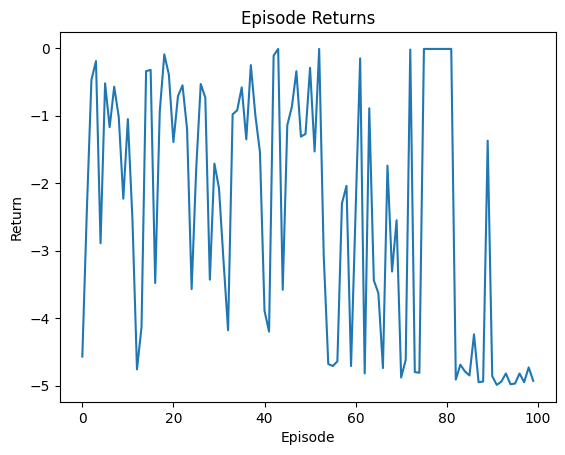

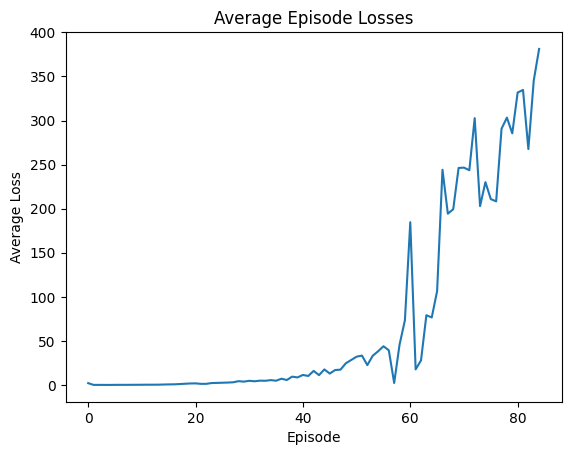

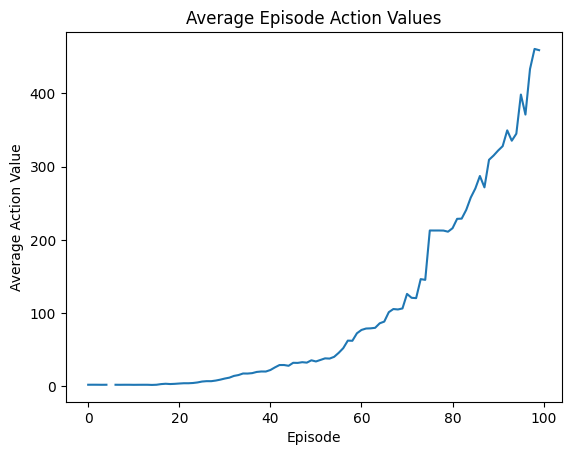

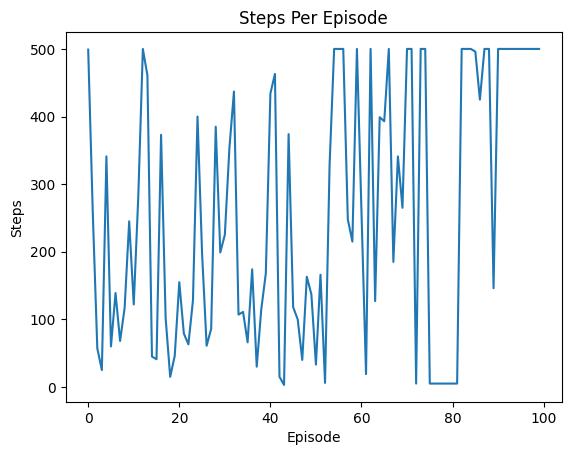

In [43]:
ACTION_SPACE = (
      nethack.CompassDirection.N,
      nethack.CompassDirection.E,
      nethack.CompassDirection.S,
      nethack.CompassDirection.W,
      nethack.CompassDirection.NE,
      nethack.CompassDirection.SE,
      nethack.CompassDirection.SW,
      nethack.CompassDirection.NW,
      nethack.CompassDirectionLonger.N,
      nethack.CompassDirectionLonger.E,
      nethack.CompassDirectionLonger.S,

      nethack.CompassDirectionLonger.W,
      nethack.CompassDirectionLonger.NE,
      nethack.CompassDirectionLonger.SE,
      nethack.CompassDirectionLonger.SW,
      nethack.CompassDirectionLonger.NW,
      nethack.MiscDirection.DOWN,
      nethack.Command.APPLY,
      nethack.Command.CAST,
      nethack.Command.CLOSE,
      nethack.Command.DIP,
      nethack.Command.DROP,
      nethack.Command.DROPTYPE,
      nethack.Command.EAT,
      nethack.Command.ENHANCE,
      nethack.Command.FIGHT,
      nethack.Command.FIRE,
      nethack.Command.FORCE,
      nethack.Command.INVOKE,
      nethack.Command.JUMP,
      nethack.Command.KICK,
      nethack.Command.LOOK,
      nethack.Command.LOOT,
      nethack.Command.MONSTER,
      nethack.Command.MOVE,
      nethack.Command.MOVEFAR,
      nethack.Command.OFFER,
      nethack.Command.OPEN,
      nethack.Command.PAY,
      nethack.Command.PICKUP,
      nethack.Command.PRAY,
      nethack.Command.PUTON,
      nethack.Command.QUAFF,
      nethack.Command.QUIVER,
      nethack.Command.READ,
      nethack.Command.REMOVE,
      nethack.Command.RIDE,
      nethack.Command.RUB,
      nethack.Command.RUSH,
      nethack.Command.SEARCH,
      nethack.Command.SHELL,
      nethack.Command.SWAP,
      nethack.Command.TAKEOFF,
      nethack.Command.TAKEOFFALL,
      nethack.Command.THROW,
      nethack.Command.TIP,
      nethack.Command.TURN,
      nethack.Command.TWOWEAPON,
      nethack.Command.UNTRAP,
      nethack.Command.WEAR,
      nethack.Command.WIELD,
      nethack.Command.WIPE,
      nethack.Command.ZAP,
      nethack.TextCharacters.PLUS,
      nethack.TextCharacters.QUOTE,
      nethack.TextCharacters.DOLLAR,
      nethack.TextCharacters.SPACE,
      )

envName = "MiniHack-Quest-Easy-v0"

hyperParams = {
    "seed": 42,  # which seed to use
    "env": envName,  # name of the game
    "replay-buffer-size": 3000,  # replay buffer size
    "learning-rate": 1e-5,  # learning rate for Adam optimizer
    "discount-factor": 1, #0.99,  # discount factor
    "num-steps": 1000000,  # total number of steps to run the environment for
    "num_max_Episodes": 100, #if num steps not reached, cap number of episodes
    "batch-size": 64,  # number of transitions to optimize at the same time
    "learning-starts": 1000,  # number of steps before learning starts
    "learning-freq": 4,  # number of iterations between every optimization step
    "use-double-dqn": True,  # use double deep Q-learning
    "target-update-freq": 100,  # number of iterations between every target network update
    "eps-start": 1.0,  # e-greedy start threshold
    "eps-end": 0.01,  # e-greedy end threshold
    "eps-fraction": 0.01,  # fraction of num-steps
    "print-freq": 1,
    "actions": ACTION_SPACE,
    }
#agentTwo = copy.deepcopy(trainedAgent)
agentThree= runEnv(hyperParams, envName)

In [44]:
makeVideo(agentThree, hyperParams, envName)

seed: 42
env: MiniHack-Quest-Easy-v0
replay-buffer-size: 3000
learning-rate: 1e-05
discount-factor: 1
num-steps: 1000000
num_max_Episodes: 100
batch-size: 64
learning-starts: 1000
learning-freq: 4
use-double-dqn: True
target-update-freq: 100
eps-start: 1.0
eps-end: 0.01
eps-fraction: 0.01
print-freq: 1
actions: (<CompassDirection.N: 107>, <CompassDirection.E: 108>, <CompassDirection.S: 106>, <CompassDirection.W: 104>, <CompassDirection.NE: 117>, <CompassDirection.SE: 110>, <CompassDirection.SW: 98>, <CompassDirection.NW: 121>, <CompassDirectionLonger.N: 75>, <CompassDirectionLonger.E: 76>, <CompassDirectionLonger.S: 74>, <CompassDirectionLonger.W: 72>, <CompassDirectionLonger.NE: 85>, <CompassDirectionLonger.SE: 78>, <CompassDirectionLonger.SW: 66>, <CompassDirectionLonger.NW: 89>, <MiscDirection.DOWN: 62>, <Command.APPLY: 97>, <Command.CAST: 90>, <Command.CLOSE: 99>, <Command.DIP: 228>, <Command.DROP: 100>, <Command.DROPTYPE: 68>, <Command.EAT: 101>, <Command.ENHANCE: 229>, <Command.F

seed: 42
env: MiniHack-Quest-Medium-v0
replay-buffer-size: 3000
learning-rate: 1e-05
discount-factor: 1
num-steps: 1000000
num_max_Episodes: 100
batch-size: 64
learning-starts: 1000
learning-freq: 4
use-double-dqn: True
target-update-freq: 100
eps-start: 1.0
eps-end: 0.01
eps-fraction: 0.01
print-freq: 1
actions: (<CompassDirection.N: 107>, <CompassDirection.E: 108>, <CompassDirection.S: 106>, <CompassDirection.W: 104>, <CompassDirection.NE: 117>, <CompassDirection.SE: 110>, <CompassDirection.SW: 98>, <CompassDirection.NW: 121>, <CompassDirectionLonger.N: 75>, <CompassDirectionLonger.E: 76>, <CompassDirectionLonger.S: 74>, <CompassDirectionLonger.W: 72>, <CompassDirectionLonger.NE: 85>, <CompassDirectionLonger.SE: 78>, <CompassDirectionLonger.SW: 66>, <CompassDirectionLonger.NW: 89>, <MiscDirection.DOWN: 62>, <Command.APPLY: 97>, <Command.CAST: 90>, <Command.CLOSE: 99>, <Command.DIP: 228>, <Command.DROP: 100>, <Command.DROPTYPE: 68>, <Command.EAT: 101>, <Command.ENHANCE: 229>, <Command

/usr/local/lib/python3.10/dist-packages/nle/env/base.py:602: UserWarning: Warning: smooth quitting of game failed, aborting.
  warnings.warn("Warning: smooth quitting of game failed, aborting.")


episode 30 done
********************************************************
Episode return: -9.969999999999832
steps: 16464
episodes: 31
mean 100 episode reward: -5.3
% time spent exploring: 1
********************************************************
episode 31 done
********************************************************
Episode return: -9.789999999999836
steps: 17464
episodes: 32
mean 100 episode reward: -5.4
% time spent exploring: 1
********************************************************
episode 32 done
********************************************************
Episode return: -9.909999999999833
steps: 18464
episodes: 33
mean 100 episode reward: -5.6
% time spent exploring: 1
********************************************************
episode 33 done
********************************************************
Episode return: -2.5599999999999894
steps: 18746
episodes: 34
mean 100 episode reward: -5.5
% time spent exploring: 1
********************************************************
episode 34 

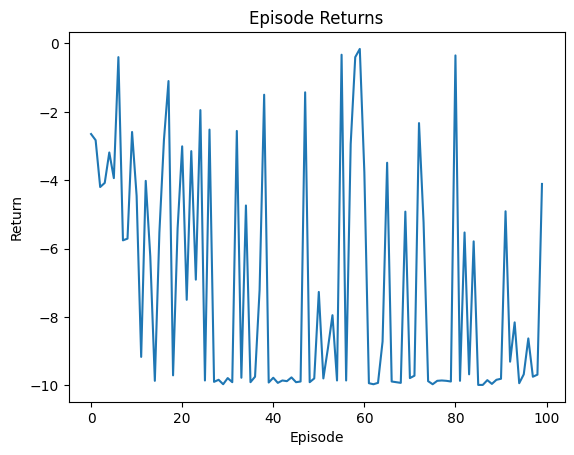

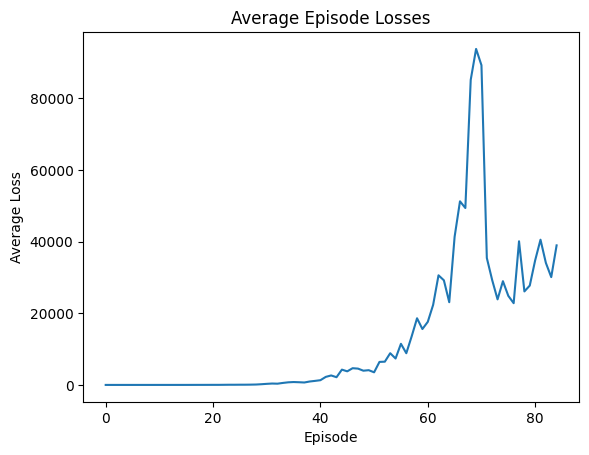

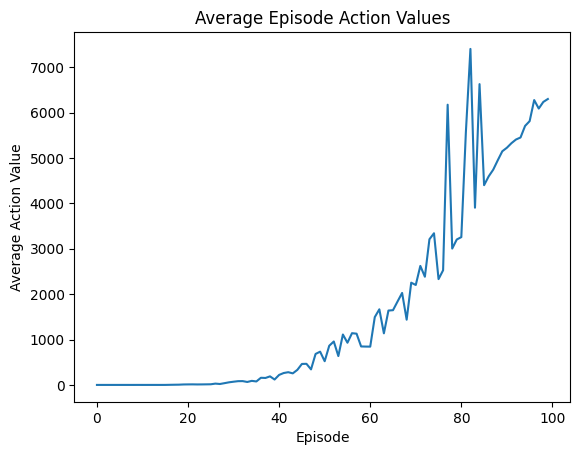

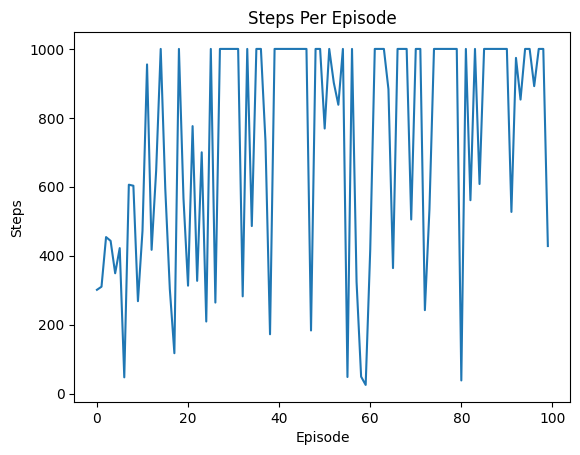

In [68]:
ACTION_SPACE = (
      nethack.CompassDirection.N,
      nethack.CompassDirection.E,
      nethack.CompassDirection.S,
      nethack.CompassDirection.W,
      nethack.CompassDirection.NE,
      nethack.CompassDirection.SE,
      nethack.CompassDirection.SW,
      nethack.CompassDirection.NW,
      nethack.CompassDirectionLonger.N,
      nethack.CompassDirectionLonger.E,
      nethack.CompassDirectionLonger.S,
      nethack.CompassDirectionLonger.W,
      nethack.CompassDirectionLonger.NE,
      nethack.CompassDirectionLonger.SE,
      nethack.CompassDirectionLonger.SW,
      nethack.CompassDirectionLonger.NW,
      nethack.MiscDirection.DOWN,
      nethack.Command.APPLY,
      nethack.Command.CAST,
      nethack.Command.CLOSE,
      nethack.Command.DIP,
      nethack.Command.DROP,
      nethack.Command.DROPTYPE,
      nethack.Command.EAT,
      nethack.Command.ENHANCE,
      nethack.Command.FIGHT,
      nethack.Command.FIRE,
      nethack.Command.FORCE,
      nethack.Command.INVOKE,
      nethack.Command.JUMP,
      nethack.Command.KICK,
      nethack.Command.LOOK,
      nethack.Command.LOOT,
      nethack.Command.MONSTER,
      nethack.Command.MOVE,
      nethack.Command.MOVEFAR,
      nethack.Command.OFFER,
      nethack.Command.OPEN,
      nethack.Command.PAY,
      nethack.Command.PICKUP,
      nethack.Command.PRAY,
      nethack.Command.PUTON,
      nethack.Command.QUAFF,
      nethack.Command.QUIVER,
      nethack.Command.READ,
      nethack.Command.REMOVE,
      nethack.Command.RIDE,
      nethack.Command.RUB,
      nethack.Command.RUSH,
      nethack.Command.SEARCH,
      nethack.Command.SHELL,
      nethack.Command.SWAP,
      nethack.Command.TAKEOFF,
      nethack.Command.TAKEOFFALL,
      nethack.Command.THROW,
      nethack.Command.TIP,
      nethack.Command.TURN,
      nethack.Command.TWOWEAPON,
      nethack.Command.UNTRAP,
      nethack.Command.WEAR,
      nethack.Command.WIELD,
      nethack.Command.WIPE,
      nethack.Command.ZAP,
      nethack.TextCharacters.PLUS,
      nethack.TextCharacters.QUOTE,
      nethack.TextCharacters.DOLLAR,
      nethack.TextCharacters.SPACE,
      )

envName = "MiniHack-Quest-Medium-v0"

hyperParams = {
    "seed": 42,  # which seed to use
    "env": envName,  # name of the game
    "replay-buffer-size": 3000,  # replay buffer size
    "learning-rate": 1e-5,  # learning rate for Adam optimizer
    "discount-factor": 1, #0.99,  # discount factor
    "num-steps": 1000000,  # total number of steps to run the environment for
    "num_max_Episodes": 100, #if num steps not reached, cap number of episodes
    "batch-size": 64,  # number of transitions to optimize at the same time
    "learning-starts": 1000,  # number of steps before learning starts
    "learning-freq": 4,  # number of iterations between every optimization step
    "use-double-dqn": True,  # use double deep Q-learning
    "target-update-freq": 100,  # number of iterations between every target network update
    "eps-start": 1.0,  # e-greedy start threshold
    "eps-end": 0.01,  # e-greedy end threshold
    "eps-fraction": 0.01,  # fraction of num-steps
    "print-freq": 1,
    "actions": ACTION_SPACE,
    }
#agentTwo = copy.deepcopy(trainedAgent)
agentThree= runEnv(hyperParams, envName)

In [69]:
print(envName)
makeVideo(agentThree, hyperParams, envName)

MiniHack-Quest-Medium-v0
seed: 42
env: MiniHack-Quest-Medium-v0
replay-buffer-size: 3000
learning-rate: 1e-05
discount-factor: 1
num-steps: 1000000
num_max_Episodes: 100
batch-size: 64
learning-starts: 1000
learning-freq: 4
use-double-dqn: True
target-update-freq: 100
eps-start: 1.0
eps-end: 0.01
eps-fraction: 0.01
print-freq: 1
actions: (<CompassDirection.N: 107>, <CompassDirection.E: 108>, <CompassDirection.S: 106>, <CompassDirection.W: 104>, <CompassDirection.NE: 117>, <CompassDirection.SE: 110>, <CompassDirection.SW: 98>, <CompassDirection.NW: 121>, <CompassDirectionLonger.N: 75>, <CompassDirectionLonger.E: 76>, <CompassDirectionLonger.S: 74>, <CompassDirectionLonger.W: 72>, <CompassDirectionLonger.NE: 85>, <CompassDirectionLonger.SE: 78>, <CompassDirectionLonger.SW: 66>, <CompassDirectionLonger.NW: 89>, <MiscDirection.DOWN: 62>, <Command.APPLY: 97>, <Command.CAST: 90>, <Command.CLOSE: 99>, <Command.DIP: 228>, <Command.DROP: 100>, <Command.DROPTYPE: 68>, <Command.EAT: 101>, <Comman

In [ ]:
ACTION_SPACE = (
      nethack.CompassDirection.N,
      nethack.CompassDirection.E,
      nethack.CompassDirection.S,
      nethack.CompassDirection.W,
      nethack.CompassDirection.NE,
      nethack.CompassDirection.SE,
      nethack.CompassDirection.SW,
      nethack.CompassDirection.NW,
      nethack.CompassDirectionLonger.N,
      nethack.CompassDirectionLonger.E,
      nethack.CompassDirectionLonger.S,
      nethack.CompassDirectionLonger.W,
      nethack.CompassDirectionLonger.NE,
      nethack.CompassDirectionLonger.SE,
      nethack.CompassDirectionLonger.SW,
      nethack.CompassDirectionLonger.NW,
      nethack.MiscDirection.DOWN,
      nethack.Command.APPLY,
      nethack.Command.CAST,
      nethack.Command.CLOSE,
      nethack.Command.DIP,
      nethack.Command.DROP,
      nethack.Command.DROPTYPE,
      nethack.Command.EAT,
      nethack.Command.ENHANCE,
      nethack.Command.FIGHT,
      nethack.Command.FIRE,
      nethack.Command.FORCE,
      nethack.Command.INVOKE,
      nethack.Command.JUMP,
      nethack.Command.KICK,
      nethack.Command.LOOK,
      nethack.Command.LOOT,
      nethack.Command.MONSTER,
      nethack.Command.MOVE,
      nethack.Command.MOVEFAR,
      nethack.Command.OFFER,
      nethack.Command.OPEN,
      nethack.Command.PAY,
      nethack.Command.PICKUP,
      nethack.Command.PRAY,
      nethack.Command.PUTON,
      nethack.Command.QUAFF,
      nethack.Command.QUIVER,
      nethack.Command.READ,
      nethack.Command.REMOVE,
      nethack.Command.RIDE,
      nethack.Command.RUB,
      nethack.Command.RUSH,
      nethack.Command.SEARCH,
      nethack.Command.SHELL,
      nethack.Command.SWAP,
      nethack.Command.TAKEOFF,
      nethack.Command.TAKEOFFALL,
      nethack.Command.THROW,
      nethack.Command.TIP,
      nethack.Command.TURN,
      nethack.Command.TWOWEAPON,
      nethack.Command.UNTRAP,
      nethack.Command.WEAR,
      nethack.Command.WIELD,
      nethack.Command.WIPE,
      nethack.Command.ZAP,
      nethack.TextCharacters.PLUS,
      nethack.TextCharacters.QUOTE,
      nethack.TextCharacters.DOLLAR,
      nethack.TextCharacters.SPACE,
      )

envName = "MiniHack-Quest-Hard-v0"

hyperParams = {
    "seed": 42,  # which seed to use
    "env": envName,  # name of the game
    "replay-buffer-size": 3000,  # replay buffer size
    "learning-rate": 1e-5,  # learning rate for Adam optimizer
    "discount-factor": 1, #0.99,  # discount factor
    "num-steps": 1000000,  # total number of steps to run the environment for
    "num_max_Episodes": 100, #if num steps not reached, cap number of episodes
    "batch-size": 64,  # number of transitions to optimize at the same time
    "learning-starts": 1000,  # number of steps before learning starts
    "learning-freq": 4,  # number of iterations between every optimization step
    "use-double-dqn": True,  # use double deep Q-learning
    "target-update-freq": 100,  # number of iterations between every target network update
    "eps-start": 1.0,  # e-greedy start threshold
    "eps-end": 0.01,  # e-greedy end threshold
    "eps-fraction": 0.01,  # fraction of num-steps
    "print-freq": 1,
    "actions": ACTION_SPACE,
    }
#agentTwo = copy.deepcopy(trainedAgent)
agentThree= runEnv(hyperParams, envName)

#NOTE RAN OUT OF COLAB GPU UNITS!!!!!!!!
#RUN CONTINUED ON ANOTHER ACCOUNT

seed: 42
env: MiniHack-Quest-Hard-v0
replay-buffer-size: 3000
learning-rate: 1e-05
discount-factor: 1
num-steps: 1000000
num_max_Episodes: 100
batch-size: 64
learning-starts: 1000
learning-freq: 4
use-double-dqn: True
target-update-freq: 100
eps-start: 1.0
eps-end: 0.01
eps-fraction: 0.01
print-freq: 1
actions: (<CompassDirection.N: 107>, <CompassDirection.E: 108>, <CompassDirection.S: 106>, <CompassDirection.W: 104>, <CompassDirection.NE: 117>, <CompassDirection.SE: 110>, <CompassDirection.SW: 98>, <CompassDirection.NW: 121>, <CompassDirectionLonger.N: 75>, <CompassDirectionLonger.E: 76>, <CompassDirectionLonger.S: 74>, <CompassDirectionLonger.W: 72>, <CompassDirectionLonger.NE: 85>, <CompassDirectionLonger.SE: 78>, <CompassDirectionLonger.SW: 66>, <CompassDirectionLonger.NW: 89>, <MiscDirection.DOWN: 62>, <Command.APPLY: 97>, <Command.CAST: 90>, <Command.CLOSE: 99>, <Command.DIP: 228>, <Command.DROP: 100>, <Command.DROPTYPE: 68>, <Command.EAT: 101>, <Command.ENHANCE: 229>, <Command.F

In [ ]:
makeVideo(agentThree, hyperParams, envName)